In [1]:
import numpy as np
import requests

%config InlineBackend.figure_formats = ['svg']
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
data = dict()

for mixture in [
    "Ar_80.0-C4H10_20.0",
    "Ar_82.5-C4H10_17.5",
    "Ar_85.0-C4H10_15.0",
    "Ar_87.5-C4H10_12.5",
]:
    url = f"https://lobis.github.io/gas-files/mixtures/Ar-C4H10/{mixture}.gas.json"
    print(url)
    r = requests.get(url)
    data[mixture] = r.json()

https://lobis.github.io/gas-files/mixtures/Ar-C4H10/Ar_80.0-C4H10_20.0.gas.json
https://lobis.github.io/gas-files/mixtures/Ar-C4H10/Ar_82.5-C4H10_17.5.gas.json
https://lobis.github.io/gas-files/mixtures/Ar-C4H10/Ar_85.0-C4H10_15.0.gas.json
https://lobis.github.io/gas-files/mixtures/Ar-C4H10/Ar_87.5-C4H10_12.5.gas.json


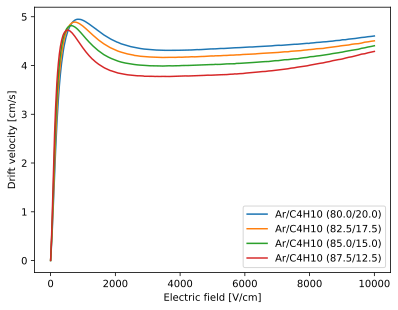

In [3]:
def mixture_string_to_label(mixture):
    words = mixture.replace("_", " ").replace("-", " ").split()
    # gases are the odd words
    gases = words[::2]
    # fractions are the even words
    fractions = words[1::2]
    assert len(gases) == len(fractions)
    return f"""{"/".join(gases)} ({"/".join(fractions)})"""


for mixture, gas in data.items():
    x = gas["electric_field"]
    y = gas["electron_drift_velocity"]
    plt.plot(x, y, label=mixture_string_to_label(mixture))

plt.xlabel("Electric field [V/cm]")
plt.ylabel("Drift velocity [cm/s]")
plt.legend()
plt.show()
